In [1]:
import pandas as pd
% load_ext autoreload
% autoreload 2
import os

os.chdir('/voyager/projects/tomginsberg/detectron')

In [74]:
from data.cifar10 import CIFAR10DataModule
from models import pretrained
from rejectron.pqmodule import PQModule
from rejectron.training_utils import benchmark, rejectron_trainer, train_rejectors
# supress all warnings
import warnings
from rejectron.rejectronstep import RejectronStep
import torch
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

In [75]:
dm = CIFAR10DataModule(test_samples=1000, negative_labels=True, shift=False, test_seed=0, shift_types='frost-fog-snow', split_val=True)

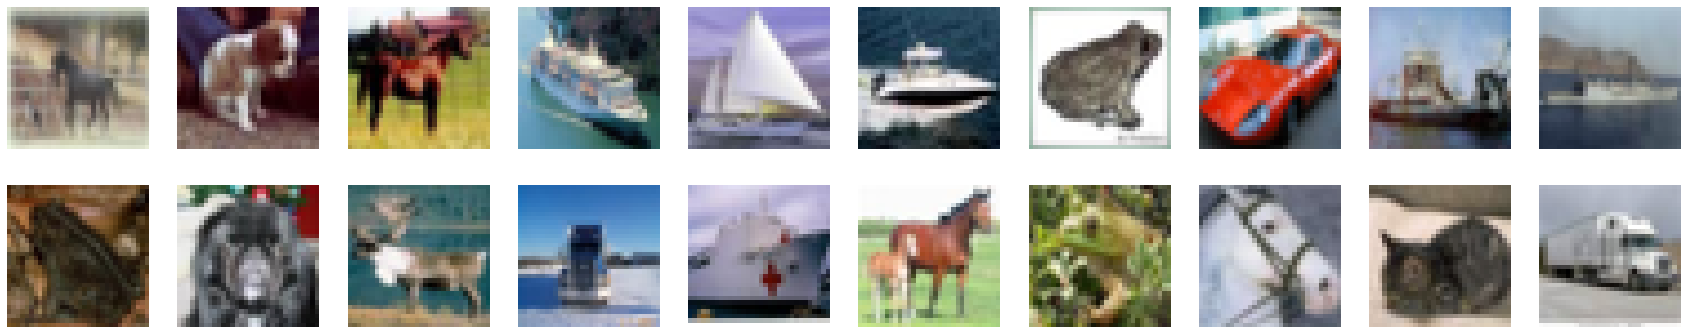

In [83]:
dm.preview(n=10)

In [87]:
h = pretrained.resnet18_trained_on_cifar10()
make_c = lambda: pretrained.resnet18_trained_on_cifar10()

In [84]:
pq = PQModule(datamodule=dm, batch_size=1024)
trainer = rejectron_trainer(dryrun=True, max_epochs=5)

In [90]:
c = make_c()
c_step = RejectronStep(h, c=c, n_train=pq.n_train, n_test=pq.n_test, init_val_acc=df['val_acc_all'].item())

In [97]:
trainer(0).fit(c_step, pq)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type                  | Params
---------------------------------------------------------------
0 | h                    | TorchvisionClassifier | 11.2 M
1 | c                    | TorchvisionClassifier | 11.2 M
2 | rejectron_metric     | RejectronMetric       | 0     
3 | rejectron_metric_val | RejectronMetric       | 0     
---------------------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.453    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 94.109
Metric val_acc_all improved. New best score: 0.878


Val Metrics:
   val_agree   val_acc  val_acc_all
0   0.887778  0.900626     0.835778
Train Metrics:
   train_agree  test_reject  train_acc  train_acc_all  test_acc  test_acc_all  \
0      0.94432        0.109   0.982845        0.94412  0.892256         0.829   

   p_q_score  
0  94.109001  


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 2.996 >= min_delta = 0.0. New best score: 97.105
Metric val_acc_all improved by 0.000 >= min_delta = 0.05. New best score: 0.878


Val Metrics:
   val_agree   val_acc  val_acc_all
0   0.894556  0.907465     0.853444
Train Metrics:
   train_agree  test_reject  train_acc  train_acc_all  test_acc  test_acc_all  \
0      0.97328        0.105   0.973533        0.95508  0.902793         0.852   

   p_q_score  
0  97.105003  


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.005 >= min_delta = 0.0. New best score: 98.110
Metric val_acc_all improved by 0.000 >= min_delta = 0.05. New best score: 0.878


Val Metrics:
   val_agree   val_acc  val_acc_all
0   0.887556  0.912494     0.854889
Train Metrics:
   train_agree  test_reject  train_acc  train_acc_all  test_acc  test_acc_all  \
0      0.98016         0.11   0.972147        0.95884  0.902247         0.844   

   p_q_score  
0  98.110001  


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.009 >= min_delta = 0.0. New best score: 98.119
Metric val_acc_all improved by 0.000 >= min_delta = 0.05. New best score: 0.878


Val Metrics:
   val_agree   val_acc  val_acc_all
0   0.889111  0.911897        0.858
Train Metrics:
   train_agree  test_reject  train_acc  train_acc_all  test_acc  test_acc_all  \
0      0.98456        0.119   0.971073        0.96152  0.908059         0.844   

   p_q_score  
0  98.119003  


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.003 >= min_delta = 0.0. New best score: 98.122
Metric val_acc_all improved by 0.000 >= min_delta = 0.05. New best score: 0.878


Val Metrics:
   val_agree   val_acc  val_acc_all
0   0.892667  0.905651     0.849333
Train Metrics:
   train_agree  test_reject  train_acc  train_acc_all  test_acc  test_acc_all  \
0      0.98632        0.122   0.970476         0.9617  0.906606         0.844   

   p_q_score  
0  98.122002  


In [98]:
c = c_step.get_c()

In [56]:
from tqdm.notebook import tqdm
import pandas as pd
from scipy.stats import binomtest

In [47]:
dm = CIFAR10DataModule(test_samples=10000, negative_labels=False, shift=True, test_seed=99,
                       shift_types='frost-fog-snow',
                       return_meta=True, batch_size=10)

In [42]:
x, (y, sev, corr) = next(iter(dm.test_dataloader()))

In [99]:
x, y = next(iter(dm.val_dataloader()))

In [49]:
l = []
for x, (y, sev, corr) in tqdm(dm.test_dataloader()):
    with torch.no_grad():
        cy = c(x).argmax(1)
        hy = h(x).argmax(1)
    l.append({'Agreement': (cy == hy).float().mean().item(),
              'Acc': (cy == y).float().mean().item(),
              'AgreeAcc': (cy[cy == hy] == y[cy == hy]).float().mean().item()})
df = pd.DataFrame(l)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'pd' is not defined

In [69]:
pval = df.Agreement.map(lambda x: binomtest(10-int(x*10), 10, 0.1, alternative='greater').pvalue)

In [71]:
(pval < 0.05).mean()

0.661

In [34]:
rej = cy != hy
rej_samples = dm.un_normalize(x[rej].permute(1, 0, 2, 3)).permute(1, 2, 3, 0).numpy()
rej_label = y[rej]
rej_sev = sev[rej]
rej_cor = corr[rej]

In [35]:
np.unique(rej_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 8,  3, 13, 12,  9, 19,  8, 13,  6,  5]))

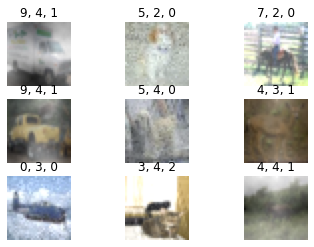

In [22]:
fig, ax = plt.subplots(3, 3)
for i, a in enumerate(ax.ravel()):
    a.imshow(rej_samples[i])
    a.set_title(f'{rej_label[i]}, {rej_sev[i]}, {rej_cor[i]}')
    a.set_axis_off()